In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
import shutil
from tqdm import tqdm

Using TensorFlow backend.


In [ ]:
N_Cls = 10
inDir = 'Dataset/DSTL'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [19]:
GS

,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.009040
1,6120_2_3,0.009169,-0.009040
2,6120_2_2,0.009188,-0.009040
3,6120_2_1,0.009188,-0.009040
4,6120_2_0,0.009188,-0.009040
5,6180_2_4,0.009169,-0.009031
6,6180_2_1,0.009169,-0.009042
7,6180_2_0,0.009156,-0.009042
8,6180_2_3,0.009188,-0.009040
9,6180_2_2,0.009188,-0.009040


In [18]:
df = DF[DF.ImageId == '6120_2_2']
df.set_index(df.ClassType, drop= True).to_dict('dict')['MultipolygonWKT']


{1: 'MULTIPOLYGON (((0.000439 -0.009039999999999999, 0.000438 -0.008999, 0.000637 -0.008985999999999999, 0.000644 -0.009039999999999999, 0.000439 -0.009039999999999999)), ((0.008607999999999999 -0.009039999999999999, 0.008564 -0.008978, 0.008666 -0.008906000000000001, 0.008770999999999999 -0.009039999999999999, 0.008607999999999999 -0.009039999999999999)), ((0.004793 -0.009039999999999999, 0.0048 -0.009032999999999999, 0.004771 -0.008996000000000001, 0.004825 -0.008954, 0.004898 -0.009039999999999999, 0.004793 -0.009039999999999999)), ((0.001432 -0.009039999999999999, 0.00143 -0.009032999999999999, 0.001671 -0.008992, 0.001682 -0.009039999999999999, 0.001432 -0.009039999999999999)), ((0.004424 -0.009039999999999999, 0.004406 -0.009021, 0.004454 -0.008985999999999999, 0.00449 -0.009039999999999999, 0.004424 -0.009039999999999999)), ((0.004142 -0.009039999999999999, 0.004131 -0.009023, 0.004174 -0.009004, 0.004191 -0.009039999999999999, 0.004142 -0.009039999999999999)), ((0.00393 -0.0090

In [7]:
DF.set_index(DF.ClassType)

,ImageId,ClassType,MultipolygonWKT
ClassType,,,
1,6040_2_2,1,MULTIPOLYGON EMPTY
2,6040_2_2,2,MULTIPOLYGON EMPTY
3,6040_2_2,3,MULTIPOLYGON EMPTY
4,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
5,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...
6,6040_2_2,6,MULTIPOLYGON EMPTY
7,6040_2_2,7,MULTIPOLYGON EMPTY
8,6040_2_2,8,MULTIPOLYGON EMPTY
9,6040_2_2,9,MULTIPOLYGON EMPTY


In [98]:
DF

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...
5,6040_2_2,6,MULTIPOLYGON EMPTY
6,6040_2_2,7,MULTIPOLYGON EMPTY
7,6040_2_2,8,MULTIPOLYGON EMPTY
8,6040_2_2,9,MULTIPOLYGON EMPTY
9,6040_2_2,10,MULTIPOLYGON EMPTY


In [ ]:
DF[DF.ImageId == '6100_2_2']

In [151]:
for name in os.listdir(inDir+'/three_band'):
    for i in DF.ImageId.unique():
        if i == name[:-4]:
            print(i)
#(DF.ImageId.unique())


6010_4_4
6040_1_3
6040_2_2
6100_2_2
6170_0_4
6140_3_1
6010_1_2
6170_2_4
6070_2_3
6140_1_2
6170_4_1
6040_4_4
6100_1_3
6120_2_2
6040_1_0
6010_4_2
6110_3_1
6160_2_1
6090_2_0
6150_2_3
6100_2_3
6110_4_0
6060_2_3
6120_2_0
6110_1_2


(3, 3349, 3391)


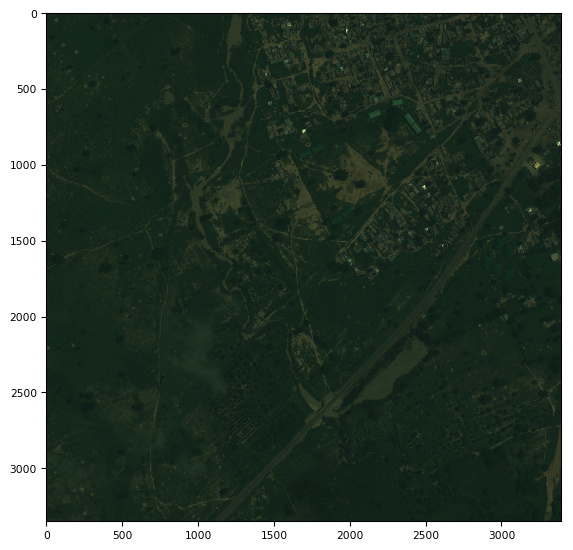

In [245]:
img = tiff.imread(inDir+'/three_band/6100_2_2.tif')
print(img.shape)
tiff.imshow(img)
plt.show()

In [152]:
img_id = '6100_2_2'
mask_multi =[]
for cls in DF.ClassType.unique():
    img = tiff.imread(inDir+'/three_band/'+img_id+'.tif')
    _, h, w = img.shape 
    mask = generate_mask_for_image_and_class((h, w), img_id, cls)
    mask_multi.append(mask)
mask_multi = np.array(mask_multi)

In [153]:
tiff.imsave('example.tif', mask_multi)

/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


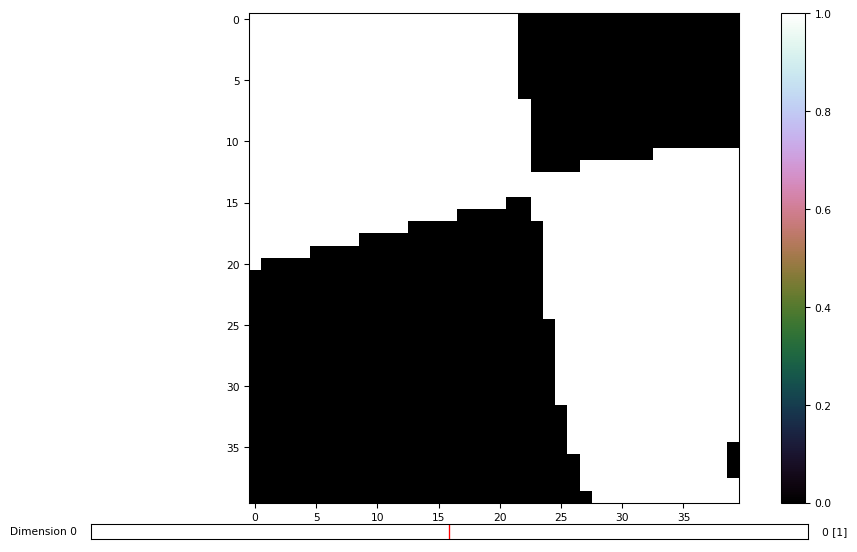

In [166]:
tiff.imshow(mask_multi[0, 60:100, 1560:1600])
plt.show()

In [80]:
'asdasdasd/asd/asd.ot'.split('/')[-1].split('.')[0]

'asd'

In [392]:
class DatasetPreparation(object):
    '''This class creates masks from polygons and generates patches dataset.'''
    def __init__(self, file_w_poly, grid_sizes, tif_folder_1 = 'Dataset/DSTL/three_band/', tif_folder_2 = None,
                 dataset_folder = 'Dataset/DSTL/'):
        self.dataset_folder = dataset_folder
        self.patch_folder = dataset_folder+'patches/'
        self.polygons = file_w_poly
        self.grid_sizes = grid_sizes
        self.tif_folder_1 = tif_folder_1
        self.tif_folder_2 = tif_folder_2
    
    # Generation of masks from polygons for images
    def _convert_coordinates_to_raster(coords, img_size, xymax):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        Xmax, Ymax = xymax
        H, W = img_size
        W1 = 1.0 * W * W / (W + 1)
        H1 = 1.0 * H * H / (H + 1)
        xf = W1 / Xmax
        yf = H1 / Ymax
        coords[:, 1] *= yf
        coords[:, 0] *= xf
        coords_int = np.round(coords).astype(np.int32)
        return coords_int


    def _get_xmax_ymin(self, grid_sizes_panda, imageId):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
        return (xmax, ymin)


    def _get_polygon_list(self, wkt_list_pandas, imageId, cType):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
        multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
        polygonList = None
        if len(multipoly_def) > 0:
            assert len(multipoly_def) == 1
            polygonList = wkt_loads(multipoly_def.values[0])
        return polygonList


    def _get_and_convert_contours(self, polygonList, raster_img_size, xymax):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        perim_list = []
        interior_list = []
        if polygonList is None:
            return None
        for k in range(len(polygonList)):
            poly = polygonList[k]
            perim = np.array(list(poly.exterior.coords))
            perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
            perim_list.append(perim_c)
            for pi in poly.interiors:
                interior = np.array(list(pi.coords))
                interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
                interior_list.append(interior_c)
        return perim_list, interior_list


    def _plot_mask_from_contours(self, raster_img_size, contours, class_value=1):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        img_mask = np.zeros(raster_img_size, np.uint8)
        if contours is None:
            return img_mask
        perim_list, interior_list = contours
        cv2.fillPoly(img_mask, perim_list, class_value)
        cv2.fillPoly(img_mask, interior_list, 0)
        return img_mask


    def generate_mask_for_image_and_class(self, raster_size, imageId, class_type):#grid_sizes_panda=GS, wkt_list_pandas=DF):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        grid_sizes_panda = self.grid_sizes
        wkt_list_pandas = self.polygons
        xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
        polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
        contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
        mask = _plot_mask_from_contours(raster_size, contours, 1)
        return mask
    
    #_____________________________________________________________________________________________________
    # Functions for patches generation from images and polygons. Grid method.
    def _create_test(self, test_id, id_list):
        test_dir = self.patch_folder+'test/'
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        if test_id == -1:
            test_id = id_list[0]
        if test_id in id_list:
            #id_list.remove(test_id)
            index = np.argwhere(id_list==test_id)
            id_list = np.delete(id_list, index)
            
            img = tiff.imread(self.tif_folder_1+test_id+'.tif')
            
            if not os.path.exists(test_dir+'images'):
                os.makedirs(test_dir+'images')
            tiff.imsave(test_dir+'images/'+test_id+'.tif', img)
            
            mask_multi =[]
            for cls in self.polygons.ClassType.unique():
                _, h, w = img.shape 
                mask = generate_mask_for_image_and_class((h, w), test_id, cls)
                mask_multi.append(mask)
            mask_multi = np.array(mask_multi)
            if not os.path.exists(test_dir+'masks'):
                os.makedirs(test_dir+'masks')
            tiff.imsave(test_dir+'masks/'+test_id+'.tif', mask_multi) 
        else: 
            print('There is no mask for this ID.')
        return id_list                
        
    def generate_patches_from_mask(self, img, mask, size, aug=True):
        _, h, w = img.shape
        
            
        for i in range(h//size[0]):
            for j in range (w//size[1]):
                h_1 = i*size[0] 
                h_2 = (i+1)*size[0]
                w_1 = j*size[1]
                w_2 = (j+1)*size[1]   
                if aug:
                    d_h = int(random.uniform(-1, 1)*size[0]*0.15 )
                    d_w = int(random.uniform(-1, 1)*size[1]*0.15)   
                    h_1+=d_h
                    h_2+=d_h
                    w_1+=d_w
                    w_2+=d_w
                h_1 = np.clip (h_1, 0, h-size[0])
                h_2 = np.clip (h_2, 0+size[0], h)
                w_1 = np.clip (w_1, 0, w-size[1])
                w_2 = np.clip (w_2, 0+size[1], w)
                patch_img = img[:,h_1:h_2,w_1:w_2]
                patch_mask = mask[:,h_1:h_2,w_1:w_2]
                
                if aug :
                    if random.uniform(0, 1) > 0.5:
                        patch_img = patch_img[:,::-1]
                        patch_mask = patch_mask[:,::-1]
                    if random.uniform(0, 1) > 0.5:
                        patch_img = patch_img[:,:, ::-1]
                        patch_mask = patch_mask[:,:, ::-1]
                
                yield patch_img, patch_mask
            # TODO: create augmentation and random crop       
        
    def _create_train(self, id_list, size = (256,256) , aug =True):
        index = 0
        for id in tqdm(id_list):
            train_dir = self.patch_folder+'train/'
            if not os.path.exists(train_dir+'images/'):
                os.makedirs(train_dir+'images/')
            if not os.path.exists(train_dir+'masks/'):
                os.makedirs(train_dir+'masks/')            
            img = tiff.imread(self.tif_folder_1+id+'.tif')
            
            mask_multi =[]
            for cls in self.polygons.ClassType.unique():
                _, h, w = img.shape 
                mask = generate_mask_for_image_and_class((h, w), id, cls)
                mask_multi.append(mask)
            mask_multi = np.array(mask_multi)
            for aug_step in range(aug*4+1):
                for patch_img, patch_mask in self.generate_patches_from_mask(img, mask_multi, size):
                    tiff.imsave(train_dir+'images/'+str(index)+'.tif', patch_img)
                    tiff.imsave(train_dir+'masks/'+str(index)+'.tif', patch_mask)
                    index +=1  
            print(index)
            
    def _create_val_from_train(self, part = 0.1):
        val_dir = self.patch_folder+'val/'
        if not os.path.exists(val_dir+'images/'):
            os.makedirs(val_dir+'images/')
        if not os.path.exists(val_dir+'masks/'):
            os.makedirs(val_dir+'masks/')  
        
        files = os.listdir(self.patch_folder+'train/images/')
        files = np.array(files)
        msk = np.random.rand(len(files)) < part
        val_names = files[msk]
        for name in val_names:
            shutil.move(self.patch_folder+'train/images/' + name, val_dir+'images/'+name)
            shutil.move(self.patch_folder+'train/masks/' + name, val_dir+'masks/'+name)
        return len(val_names)
        
    def generate_patches_from_poly(self, size = (256,256), aug=True, test_id= None):
        '''Function for patches generation from tif and polygons. Saves results on hard drive.'''
        id_list = self.polygons.ImageId.unique()
        if test_id is not None:
            id_list = self._create_test(test_id, id_list)
        print('Test set was created.')
        self._create_train(id_list, aug=aug)
        print('Train set was created.')
        self._create_val_from_train()
        print('Validation set was created')
        
    #__________________________________________________________________________________________
    # Patches generation from images and polygons. Random method.
#    def _generate_patch(self, img, mask, x, y, size=(256,256), aug=True):
#         _, h, w = img.shape
#         h_1 = x
#         h_2 = x+size[0]
#         w_1 = y
#         w_2 = y+size[1]   
#         # Augmentation
#         if aug =
#         h_1 = np.clip (h_1, 0, h-size[0])
#         h_2 = np.clip (h_2, 0+size[0], h)
#         w_1 = np.clip (w_1, 0, w-size[1])
#         w_2 = np.clip (w_2, 0+size[1], w)
#         patch_img = img[:,h_1:h_2,w_1:w_2]
#         patch_mask = mask[:,h_1:h_2,w_1:w_2]
#         return patch_img, patch_mask
    
#     def static_patch_generator(self, id_list, size = (256,256), aug = True, random = 0):
#         index = 0
#         for id in tqdm(id_list):
#             train_dir = self.patch_folder+'train/'
#             if not os.path.exists(train_dir+'images/'):
#                 os.makedirs(train_dir+'images/')
#             if not os.path.exists(train_dir+'masks/'):
#                 os.makedirs(train_dir+'masks/')            
#             img = tiff.imread(self.tif_folder_1+id+'.tif')
#             _, h, w = img.shape
#             mask_multi =[]
            
#             for cls in self.polygons.ClassType.unique():
#                 mask = generate_mask_for_image_and_class((h, w), id, cls)
#                 mask_multi.append(mask)
#             mask_multi = np.array(mask_multi)
#             if random == 0:
#                 for i in range(h//size[0]):
#                     for j in range (w//size[1]):
#                         patch_img, patch_mask = self._generate_patch(img, mask_multi, size, i*size[0], j*size[1], aug)
#                         tiff.imsave(train_dir+'images/'+str(index)+'.tif', patch_img)
#                         tiff.imsave(train_dir+'masks/'+str(index)+'.tif', patch_mask)
#                         index +=1
#             else:

In [393]:
DatasetPreparation(DF, GS).generate_patches_from_poly(test_id='6010_4_2')


  0%|          | 0/24 [00:00<?, ?it/s]

Test set was created.



  4%|▍         | 1/24 [00:08<03:04,  8.01s/it]

845



Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/user/anaconda3/envs/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  8%|▊         | 2/24 [00:17<03:15,  8.90s/it]

1690


 12%|█▎        | 3/24 [00:26<03:08,  8.96s/it]

2535


 17%|█▋        | 4/24 [00:28<02:24,  7.23s/it]

3380


 21%|██        | 5/24 [00:33<02:07,  6.72s/it]

4225


 25%|██▌       | 6/24 [00:43<02:09,  7.19s/it]

5070


 29%|██▉       | 7/24 [00:53<02:10,  7.65s/it]

5915


 33%|███▎      | 8/24 [01:03<02:07,  7.95s/it]

6760


 38%|███▊      | 9/24 [01:12<02:01,  8.09s/it]

7605


 42%|████▏     | 10/24 [01:22<01:55,  8.26s/it]

8450


 46%|████▌     | 11/24 [01:35<01:52,  8.68s/it]

9295


 50%|█████     | 12/24 [01:46<01:46,  8.91s/it]

10140


 54%|█████▍    | 13/24 [01:56<01:38,  8.92s/it]

10985


 58%|█████▊    | 14/24 [02:08<01:32,  9.20s/it]

11830


 62%|██████▎   | 15/24 [02:17<01:22,  9.15s/it]

12675


 67%|██████▋   | 16/24 [02:28<01:14,  9.29s/it]

13520


 71%|███████   | 17/24 [02:40<01:06,  9.44s/it]

14365


 75%|███████▌  | 18/24 [02:52<00:57,  9.58s/it]

15210


 79%|███████▉  | 19/24 [03:08<00:49,  9.92s/it]

16055


 83%|████████▎ | 20/24 [03:23<00:40, 10.19s/it]

16900


 88%|████████▊ | 21/24 [03:36<00:30, 10.30s/it]

17745


 92%|█████████▏| 22/24 [03:50<00:20, 10.48s/it]

18590


 96%|█████████▌| 23/24 [04:05<00:10, 10.66s/it]

19435


100%|██████████| 24/24 [04:24<00:00, 11.02s/it]

20280
Train set was created.


Validation set was created


In [75]:
DF.ImageId.unique()

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'], dtype=object)

In [76]:
def calculate_mean_std(id_list, dataset_folder):
    
    means = 
    stds = 
    for id in id_list:
        img = tiff.imread(dataset_folder+id+'.tif')
        imgs.append(img)
    imgs = np.array(imgs)
    std = np.std(imgs)
    mean = np.mean(imgs)
    return mean, std
calculate_mean_std(DF.ImageId.unique(), 'Dataset/DSTL/three_band/')

ValueError: could not broadcast input array from shape (3,3349,3391) into shape (3)

(3, 3349, 3391)
(3349, 3391, 3)


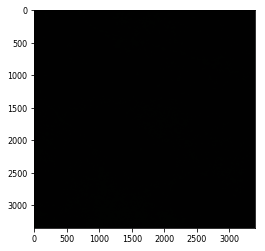

0.00985714285714
0.00560714285714


In [74]:
img = tiff.imread('Dataset/DSTL/three_band/6040_2_2.tif')/
print(img.shape)
img_new = np.copy(img[:,0:1000,0:1000])
# tiff.imshow(img_new)
# tiff.imshow(img)
#plt.imshow()
img = np.rollaxis(img, 0, 3)
print(img.shape)
plt.imshow(img)
plt.show()
print(np.max(img))
print(img_new[0,100,100])


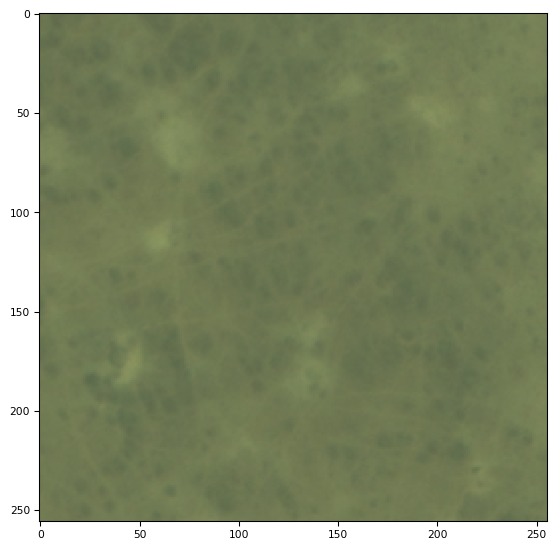

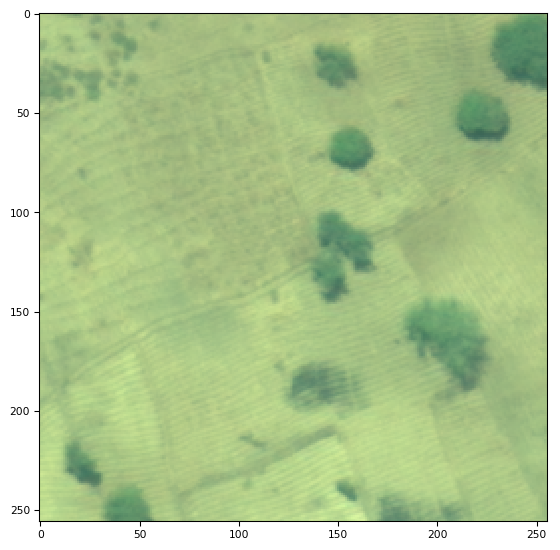

In [12]:
img1 = tiff.imread('Dataset/DSTL/patches/train/images/'+os.listdir('Dataset/DSTL/patches/train/images/')[0])
img2 = tiff.imread('Dataset/DSTL/patches/train/images/'+os.listdir('Dataset/DSTL/patches/train/images/')[1])
tiff.imshow(img1)
tiff.imshow(img2)
plt.show()

In [37]:
test = np.uint16(39)
print(type(test))

<class 'numpy.uint16'>


In [ ]:
class BatchGenerator(object):
    
    def __init__(self, batch_size = 32, dim_x = 224, dim_y = 224, dim_z = 3, shuffle = True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size = batch_size
        self.shuffle = shuffle

    def generate(self, labels, pic_names):
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(pic_names)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_IDs_temp = [pic_names[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, pic_names):
        
        # Find exploration order
        indexes = np.arange(len(pic_names))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size), dtype = np.float32)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store volume
            img = cv2.imread('Dataset/images/'+ID)
            img = cv2.resize(img,(224,224))
            img = img/255
            #print(img)
            X[i, :, :, :] = img
            #print(X)

            # Store class
            y[i] = labels[labels.id == ID].likes#labels[int(ID[:-4])]
            #print(labels.iloc[int(ID[:-4])].likes)
        return X, y
    def debug(self, labels, pic_names):
        indexes = self.__get_exploration_order(pic_names)
        imax = int(len(indexes)/self.batch_size)
        
        for i in range(1):
            # Find list of IDs
            list_IDs_temp = [pic_names[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

            # Generate data
            X, y = self.__data_generation(labels, list_IDs_temp)
            print(X.shape)
DataGenerator().debug(dataset_train, train_names)

In [26]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask


def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def stick_all_train():
    print ("let's stick all imgs together")
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print (len(ids))
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print (img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print (np.amax(y), np.amin(y))

    np.save('data/x_trn_%d' % N_Cls, x)
    np.save('data/y_trn_%d' % N_Cls, y)


def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print (x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    return x, y


def make_val():
    print ("let's pick some samples for validation")
    img = np.load('data/x_trn_%d.npy' % N_Cls)
    msk = np.load('data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

    np.save('data/x_tmp_%d' % N_Cls, x)
    np.save('data/y_tmp_%d' % N_Cls, y)


def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model


def calc_jacc(model):
    img = np.load('data/x_tmp_%d.npy' % N_Cls)
    msk = np.load('data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print (i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


def train_net():
    print ("start train net")
    x_val, y_val = np.load('data/x_tmp_%d.npy' % N_Cls), np.load('data/y_tmp_%d.npy' % N_Cls)
    img = np.load('data/x_trn_%d.npy' % N_Cls)
    msk = np.load('data/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    model.load_weights('weights/unet_10_jk0.7878')
    model_checkpoint = ModelCheckpoint('weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print ('val jk', score)
        model.save_weights('weights/unet_10_jk%.4f' % score)

    return model


def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]


def predict_test(model, trs):
    print ("predict test")
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('msk/10_%s' % id, msk)
        if i % 100 == 0: print( i, id)


def make_submit():
    print ("make submission file")
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print (df.head())
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load('msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print (idx)
    print (df.head())
    df.to_csv('subm/1.csv', index=False)


def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights('weights/unet_10_jk0.7878')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()


# if __name__ == '__main__':
#     stick_all_train()
#     make_val()
#     model = train_net()
#     score, trs = calc_jacc(model)
#     predict_test(model, trs)
#     make_submit()

#     # bonus
#     check_predict()